Задание №1. Создание дата фрейма на основе данных с сайта дом.рф

In [ ]:
import requests
import json
import pandas as pd
from sqlalchemy import create_engine

offset_ = 0
limit_ = 5000
url = f'https://xn--80az8a.xn--d1aqf.xn--p1ai/%D1%81%D0%B5%D1%80%D0%B2%D0%B8%D1%81%D1%8B/api/kn/object?offset={offset_}&limit={limit_}&sortField=devId.devShortCleanNm&sortType=asc&objStatus=0'
res = requests.get(url)
objects_data=res.json()
objects_list = objects_data.get('data').get('list')
objids = [x.get('objId') for x in objects_list] 

arr_obj = []
for i in range(0, len(objids)):
   url = f'https://xn--80az8a.xn--d1aqf.xn--p1ai/%D1%81%D0%B5%D1%80%D0%B2%D0%B8%D1%81%D1%8B/api/object/{objids[i]}'
   res = requests.get(url).json().get('data')
   dev = res.get('developer')
   del res['developer']
   
   key = 'photoRenderDTO'
   if key in res:
      del res[key]
   key = 'quartography'
   if key in res:
      del res[key]
   key = 'orgForm'
   if key in dev:
      del dev[key]
   
   res.update(dev)
   arr_obj.append(res)

with open("data_file.json", "w") as write_file:
   json.dump(arr_obj, write_file, sort_keys=False, indent=4, ensure_ascii=True, separators=(',', ': '))

base = pd.read_json('data_file.json', encoding='ISO-8859–1')
df = pd.DataFrame(base).fillna(0)

#экспорт в excel
excel_file = pd.ExcelWriter('save_pandas.xlsx')
df.to_excel(excel_file)
excel_file.save()

#экспорт в pickle
df.to_pickle('save_pandas.pkl')

#экспорт в БД
engine = create_engine('sqlite:///save_pandas.db', echo=True)
sqlite_connection = engine.connect()
sqlite_table = "ЖК"
df.to_sql(sqlite_table, sqlite_connection, if_exists='append')

Задание №2. Построение графиков

1. Распределение цены за квадрат по регионам

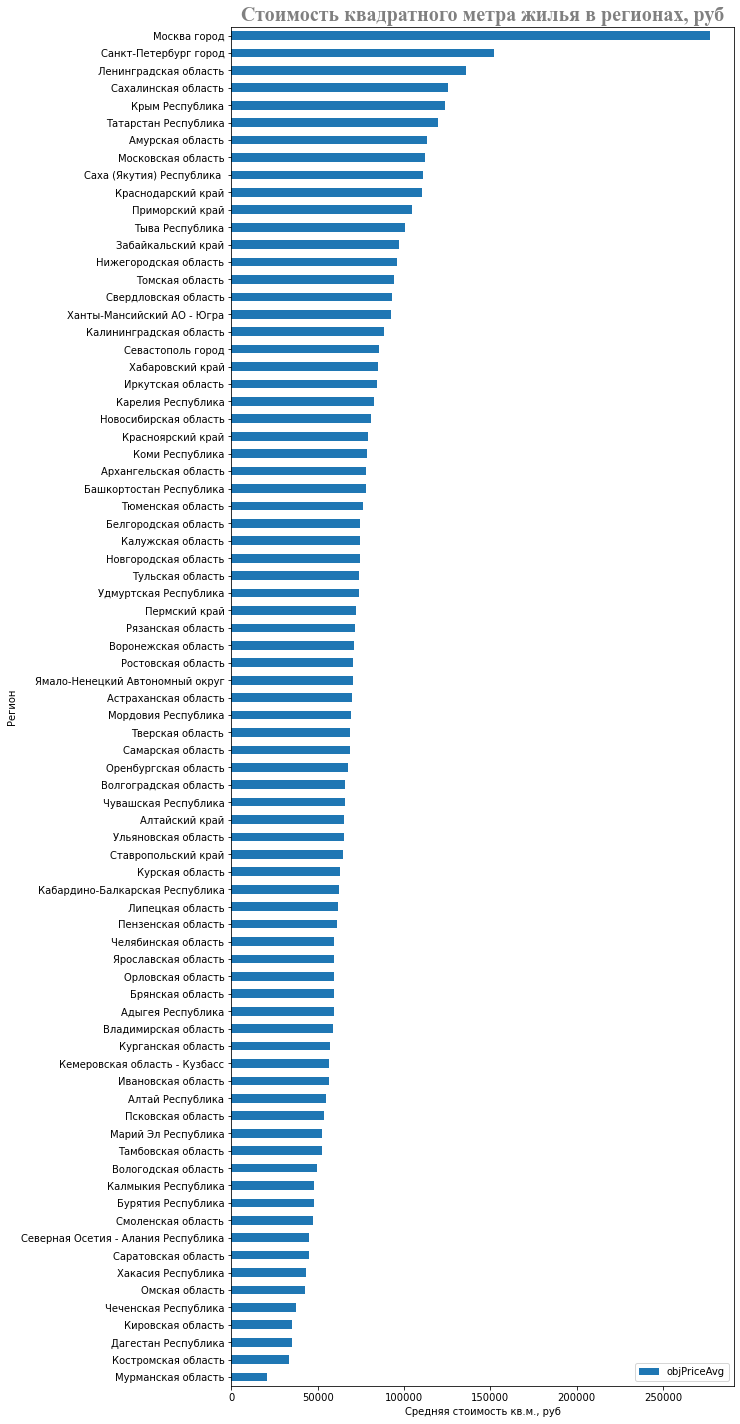

In [2]:
import os
from tkinter import CENTER
from tkinter.tix import INTEGER
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
pd.options.mode.chained_assignment = None

base = pd.read_json('data_file.json', encoding='ISO-8859–1')
df = pd.DataFrame(base).fillna(0)

#Подготовка данных: средняя стоимость квадрата по регионам
df_modifide=df.loc[(df['regRegionDesc'] != 0)&(df['objPriceAvg'] > 0)]
df_avr_price=df_modifide.groupby('regRegionDesc').agg({'objPriceAvg':'mean'})
rcParams['figure.figsize'] = 9,25

#построение графика и украшательство
df_avr_price.sort_values(by='objPriceAvg',ascending=True).plot(kind='barh')
title_dict = {'fontsize':20, 
              'fontweight':'bold',
              'color':'#808080',
             'family':'Times New Roman'}
plt.title('Стоимость квадратного метра жилья в регионах, руб',fontdict=title_dict, loc=CENTER)
plt.xlabel('Средняя стоимость кв.м., руб')
plt.ylabel('Регион')
plt.show()


На вышеприведенном графике можно увидеть список регионов РФ, расположеных в порядке убывания цены за квадратный метр строящегося жилья.
Самый дорогой регион ожидаемо Москва, стоимость жилья в Питере почти в два раза ниже. Самая дешевая недвижимость в Мурманской области (у меня в базе на основе всего 1 ЖК).

2. Тепловая карта

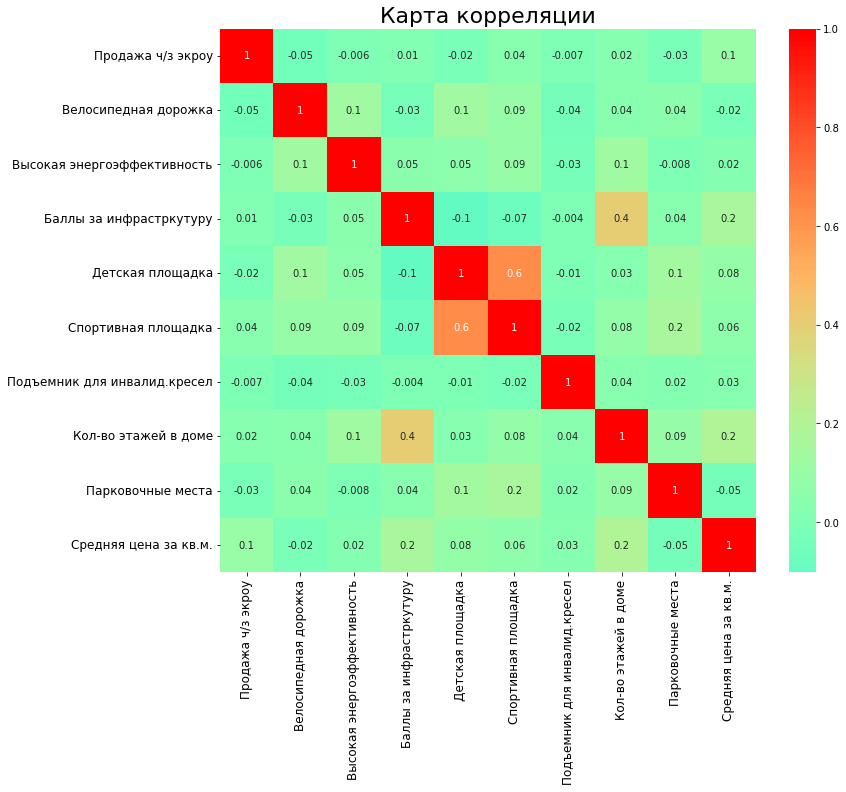

In [4]:

df_plot = df_modifide.loc[:,['objGuarantyEscrowFlg','objInfrstrBicycleLaneFlg','objGreenHouseFlg',
'infrastructureIndexValue','metro','objInfrstrPlaygrndCnt','objInfrstrSportGroundCnt','objElevatorWheelchairCnt','floorMax','objLivCeilingHeight','objInfrstrObjPrkngCnt','objPriceAvg']]

df_plot.rename(columns=
    {'objGuarantyEscrowFlg': 'Продажа ч/з экроу',
    'objInfrstrBicycleLaneFlg': 'Велосипедная дорожка',
    'objGreenHouseFlg': 'Высокая энергоэффективность',
    'infrastructureIndexValue': 'Баллы за инфрастркутуру',
    'metro': 'Метро',
    'objInfrstrPlaygrndCnt': 'Детская площадка',
    'objInfrstrSportGroundCnt': 'Спортивная площадка',
    'objElevatorWheelchairCnt': 'Подъемник для инвалид.кресел',
    'floorMax': 'Кол-во этажей в доме',
    'objLivCeilingHeight': 'Высота потолков',
    'objInfrstrObjPrkngCnt': 'Парковочные места',
    'objPriceAvg': 'Средняя цена за кв.м.',
    },
     inplace=True)

rcParams['figure.figsize'] = 12,10

sns.heatmap(df_plot.corr(), annot=True, fmt='.1g', center= 0, cmap= 'rainbow')

#plt.figure(figsize=(10,8), dpi= 80)
#sns.pairplot(df_plot, kind="scatter", plot_kws=dict(s=80, edgecolor="white", linewidth=2.5))
#plt.show()

# Decorations
plt.title('Карта корреляции', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

На тепловой карте видны попарные зависимости величин. По данный из датафрейма видим, что из выбрнных параметров ни один не оказывает сущетсвенное влияние на среднюю цену. Единственные зависимые величины - наличие детской площадки влияет на наличие площадки спортивной, так же зависимость наблюдается между оценкой инфраструктуры и этажностью дома.

3. Объем сдачи жилья по регионам и годам

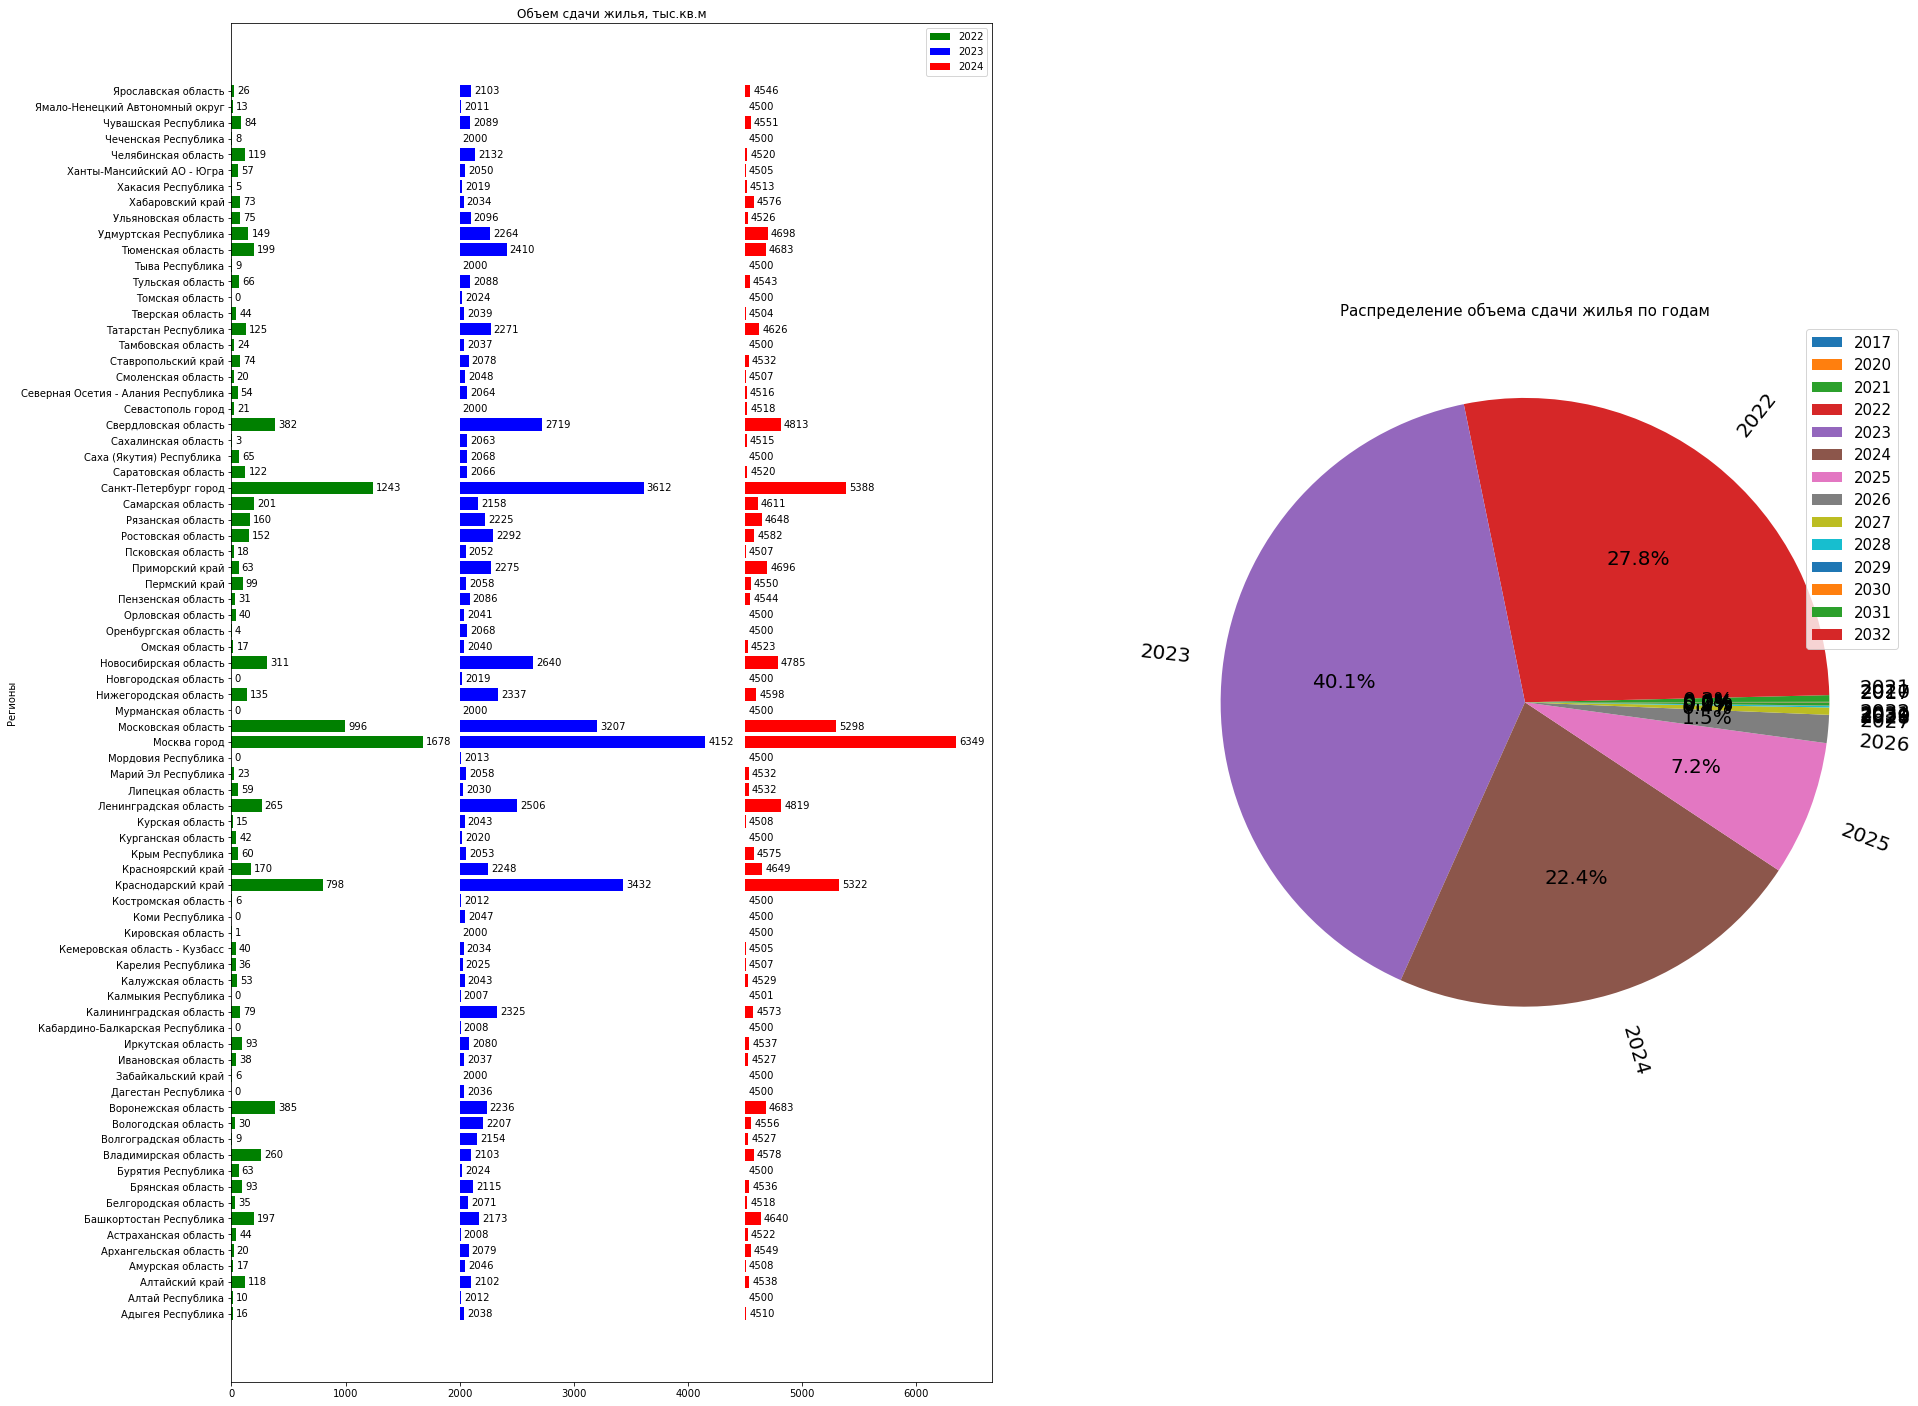

In [135]:
from cmath import log
from turtle import right

#подготовка данных для шкалы
df_part = df_modifide.loc[:,['regRegionDesc','objReady100PercDt','objFlatSq']]
df_part['objReady100PercDt'] = df_part['objReady100PercDt'].astype("datetime64[ns]")
df_part['objFlatSq'] = df_part['objFlatSq'].astype('float')
df_part['objReady100PercDt'] = df_part['objReady100PercDt'].dt.to_period("Y")
df_part = df_part.groupby(['regRegionDesc','objReady100PercDt']).agg({'objFlatSq':'sum'}).reset_index()
df_part['objReady100PercDt']=df_part['objReady100PercDt'].astype(str)

#подготовка данных для круговой диаграммы
df_circle = df_part.groupby(['objReady100PercDt']).agg({'objFlatSq':'sum'}).reset_index()
df_circle['objReady100PercDt']=df_circle['objReady100PercDt'].astype(int)
df_circle_1=df_circle.set_index(['objReady100PercDt'])


#список регионов
region_list = df_part['regRegionDesc'].unique()

#формируем списки со значениемя для каждого года отдельно
list_val_2022=[]
list_val_2023=[]
list_val_2024=[]

for x in range(0,len(region_list)):
    count=0
    for y in range(0,len(df_part)-1):
        if region_list[x]==df_part.loc[y]['regRegionDesc'] and df_part.loc[y]['objReady100PercDt']=='2022':
            list_val_2022.append(round(df_part.loc[y]['objFlatSq']/1000, 0))
            count=1
    if count==0:
        list_val_2022.append(0)


for x in range(0,len(region_list)):
    count=0
    for y in range(0,len(df_part)-1):
        if region_list[x]==df_part.loc[y]['regRegionDesc'] and df_part.loc[y]['objReady100PercDt']=='2023':
            list_val_2023.append(round(df_part.loc[y]['objFlatSq']/1000, 0))
            count=1
    if count==0:
        list_val_2023.append(0)

for x in range(0,len(region_list)):
    count=0
    for y in range(0,len(df_part)-1):
        if region_list[x]==df_part.loc[y]['regRegionDesc'] and df_part.loc[y]['objReady100PercDt']=='2024':
            list_val_2024.append(round(df_part.loc[y]['objFlatSq']/1000, 0))
            count=1
    if count==0:
        list_val_2024.append(0)

#параметры фигуры
fig = plt.figure()
rcParams['figure.figsize'] = 30,25
ax_1 = fig.add_subplot(1, 2, 1)
ax_2 = fig.add_subplot(1, 2, 2)

#отрисовка первого грфика
rects1 = ax_1.barh(region_list, list_val_2022, 0.8, label='2022', color='green')
rects2 = ax_1.barh(region_list, list_val_2023, 0.8, left=2000, label='2023', color='blue')
rects3 = ax_1.barh(region_list, list_val_2024, 0.8, left=4500, label='2024', color='red')

#декорация первого графика
ax_1.set_ylabel('Регионы')
ax_1.set_title('Объем сдачи жилья, тыс.кв.м')
plt.yticks(fontsize=15)
ax_1.legend()
ax_1.bar_label(rects1, padding=3)
ax_1.bar_label(rects2, padding=3)
ax_1.bar_label(rects3, padding=3)

#построение круговой диаграмы
ax_2.pie(df_circle_1['objFlatSq'], autopct='%1.1f%%', rotatelabels=True,labels=df_circle_1.index,textprops={'fontsize': 20})
ax_2.legend(fontsize=15)
ax_2.set_title('Распределение объема сдачи жилья по годам', fontsize=15)


plt.show()

Из круговой диаграммы видим, что практически все объекты планируются к сдаче в течение ближайших 3х лет, максимальный объем приходится на 2023 год. Среди регионов лидером ожидаемо оказалась Москва, затем Питер, Краснодарский край и Московская область.

Задание №3. Реализация с помощью объектно-ориентированного подхода

In [146]:
import requests
import json
import pandas as pd
from sqlalchemy import create_engine

1. Класс, формирующий датафрейм

In [ ]:


class Loader_DR:
    """Класс принимает параметры offset и limit и формирует датафрейм.
    Методы класса позволяют получить список id объектов, сам датафрейм"""
    def __init__(self, offset, limit):
        self.offset = offset
        self.limit = limit
    
    def change_offset(self,offset):
        self.offset = offset

    def change_limit(self,limit):
        self.limit= limit

    def get_object_list(self):
        """формирует список объектов с сайта дом.рф"""
        url = f'https://xn--80az8a.xn--d1aqf.xn--p1ai/%D1%81%D0%B5%D1%80%D0%B2%D0%B8%D1%81%D1%8B/api/kn/object?offset={self.offset}&limit={self.limit}&sortField=devId.devShortCleanNm&sortType=asc&objStatus=0'
        res = requests.get(url)
        objects_data=res.json()
        objects_list = objects_data.get('data').get('list')
        objids = [x.get('objId') for x in objects_list] 
        return objids

    def load_dataframe(self, objids):
        """формирует список объектов с сайта дом.рф"""
        arr_obj = []
        for i in range(0, len(objids)):
            url = f'https://xn--80az8a.xn--d1aqf.xn--p1ai/%D1%81%D0%B5%D1%80%D0%B2%D0%B8%D1%81%D1%8B/api/object/{objids[i]}'
            res = requests.get(url).json().get('data')
            dev = res.get('developer')
            del res['developer']
   
            key = 'photoRenderDTO'
            if key in res:
                del res[key]
            key = 'quartography'
            if key in res:
                del res[key]
            key = 'orgForm'
            if key in dev:
                del dev[key]
   
            res.update(dev)
            arr_obj.append(res)
        with open("data_file.json", "w") as write_file:
            json.dump(arr_obj, write_file, sort_keys=False, indent=4, ensure_ascii=True, separators=(',', ': '))

        base = pd.read_json('data_file.json', encoding='ISO-8859–1')
        df = pd.DataFrame(base).fillna(0)
        return df    




In [ ]:
#использование класса для загрузки

In [ ]:
el = Loader_DR(0,5000)
el.change_limit(10)
a = []
a= el.get_object_list()
df = el.load_dataframe(a)

2. Класс, сохраняющий датафрейм в разных форматах

In [175]:
class Saver:
    """по умолчанию метод save_df сохраняет в excel, можно отдельным методом изменить тип на 1 из 3х
    и также отдельным методом сохранить в текущую директорию"""
    def __init__(self):
        self.type = 'xlsx'

    def chg_type(self,type):
        self.type=type

    def save_df(self,df,file_name):
        if self.type == 'xlsx':
            name_file = file_name+'.'+self.type
            df.to_excel(name_file)
            print('Датафрейм успешно сохранен в файл excel!')
        else:
            if self.type == 'pkl':
                name_file = file_name+'.'+self.type
                df.to_pickle(name_file)
                print('Датафрейм успешно сохранен в файл pickle!')
            else:
                if self.type == 'csv':
                    name_file = file_name+'.'+self.type
                    df.to_csv(name_file)
                    print('Датафрейм успешно сохранен в файл: csv!')
                else:
                    print("Файл может быть сохранен только в форматы excel('xlsx'), csv('csv') и pickle ('pkl')")

In [177]:
obj = Saver()    
obj.save_df(df,'data_xl') 
obj.chg_type('pkl')
obj.save_df(df,'data_pkl') 

Датафрейм успешно сохранен в файл: {name_file}!
Датафрейм успешно сохранен в файл: {name_file}!


3. Класс, русующий график

In [198]:
class Draw_barh:
    """Формирует списки значений для barh"""
    def __init__(self,year):
        self.year = year

    def chg_year(self,year):
        self.year = year


    def take_data(self,legion_list,df_part):
        list_val=[]
        for x in range(0,len(region_list)):
            count=0
            for y in range(0,len(df_part)-1):
                if region_list[x]==df_part.loc[y]['regRegionDesc'] and df_part.loc[y]['objReady100PercDt']=='2022':
                    list_val.append(round(df_part.loc[y]['objFlatSq']/1000, 0))
                    count=1
            if count==0:
                list_val.append(0)
            
        return list_val
    
    def draw_barh(self,list_year,region_list,list_val,ax):
        rects1 = ax.barh(region_list, list_val, 0.8, label='2022', color='green')

        

Использование класса для отрисовки графика из задания выше:

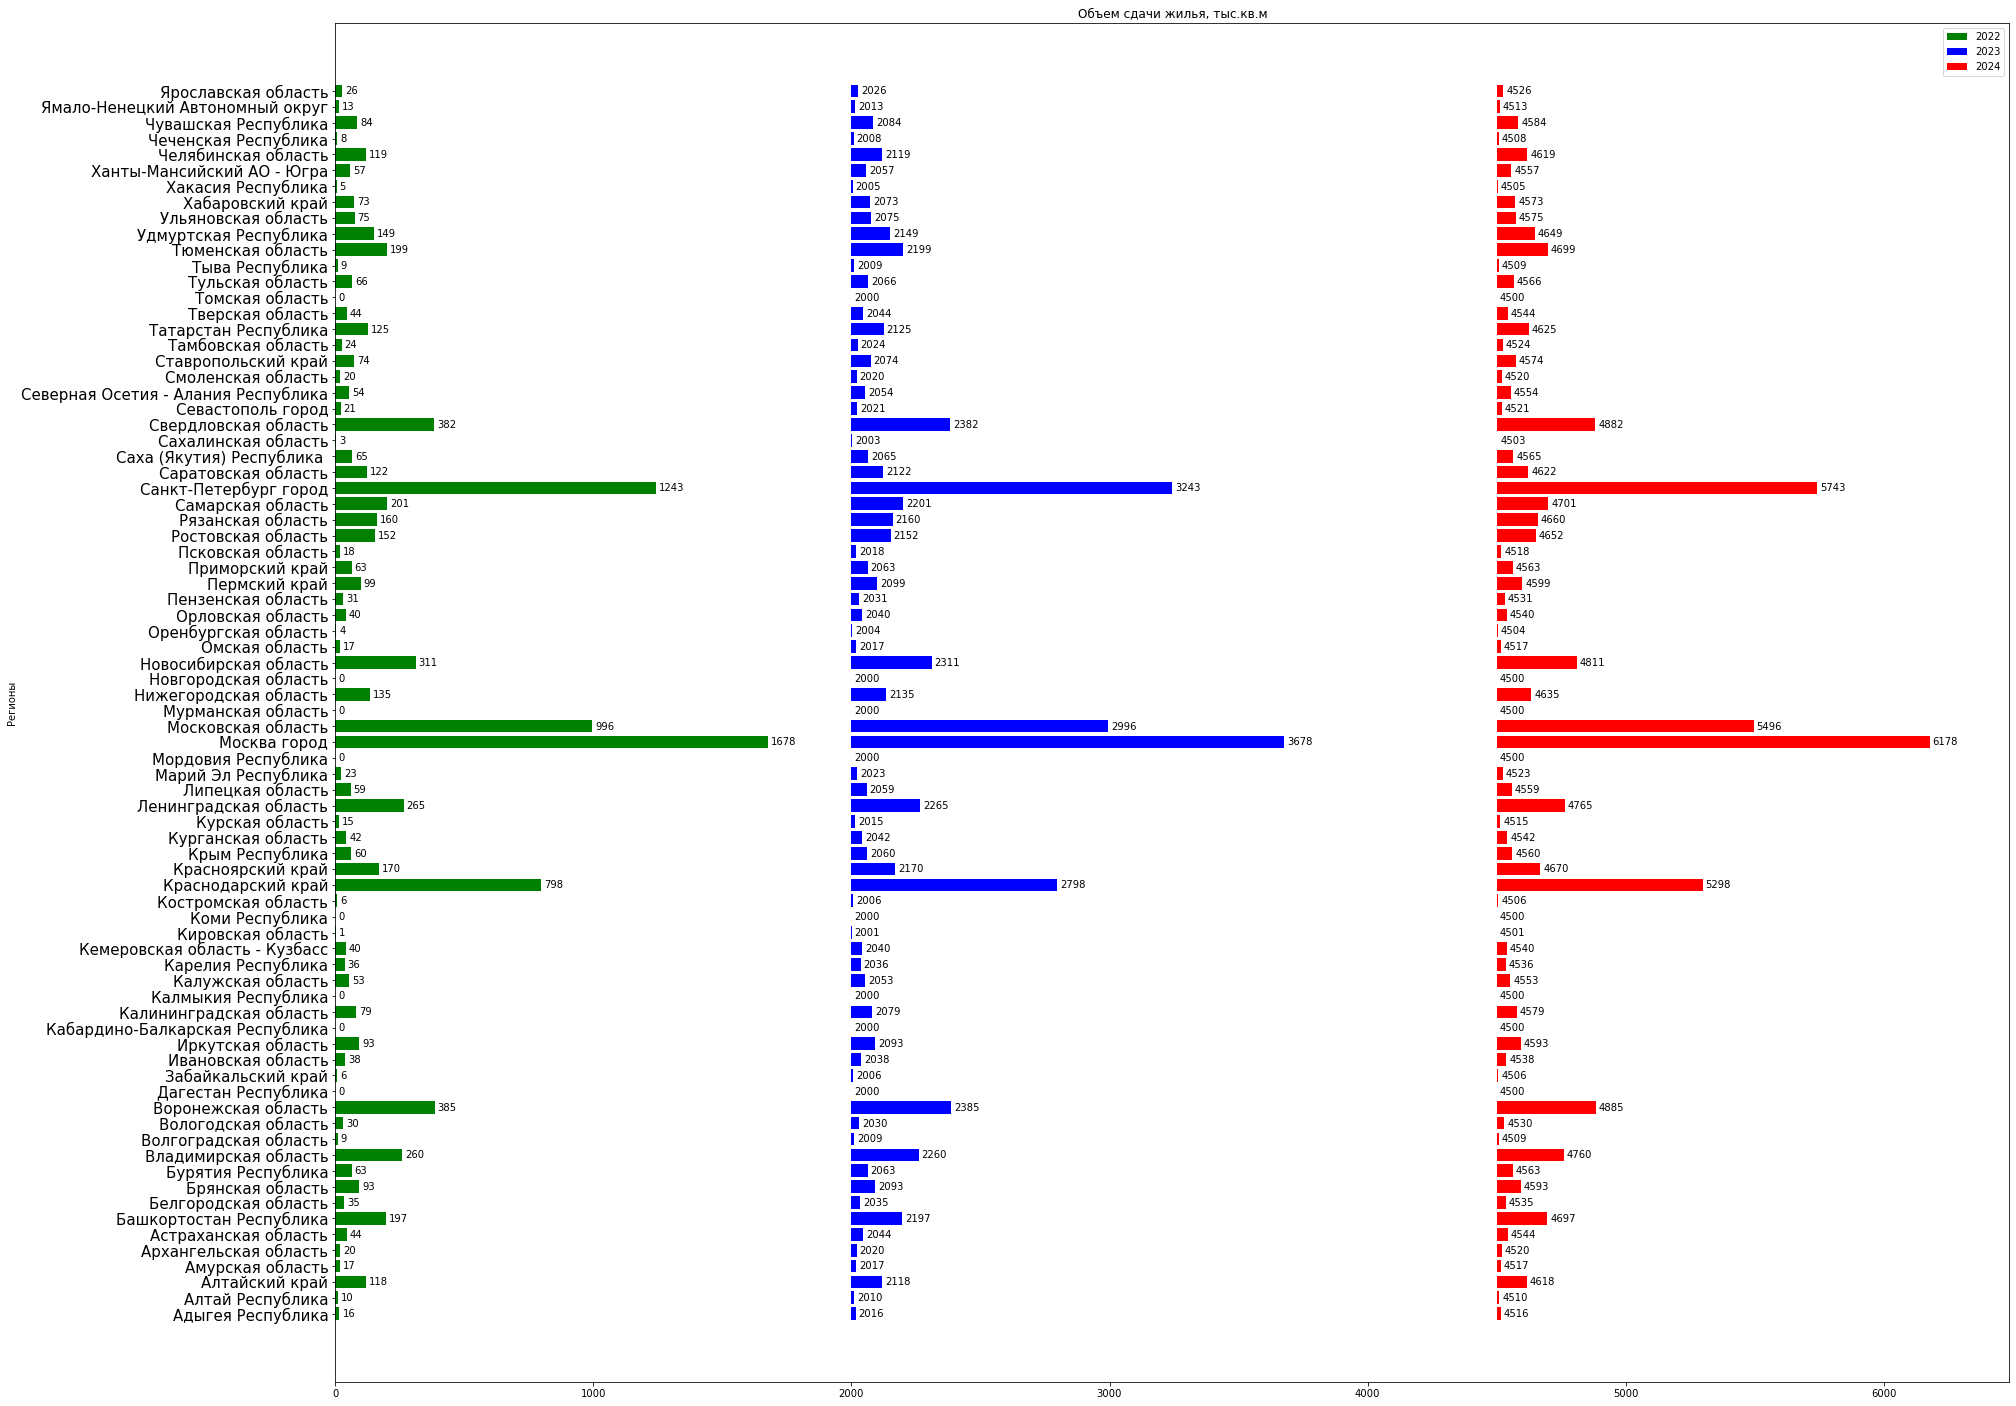

In [201]:
#подготовка данных для шкалы
df_part = df_modifide.loc[:,['regRegionDesc','objReady100PercDt','objFlatSq']]
df_part['objReady100PercDt'] = df_part['objReady100PercDt'].astype("datetime64[ns]")
df_part['objFlatSq'] = df_part['objFlatSq'].astype('float')
df_part['objReady100PercDt'] = df_part['objReady100PercDt'].dt.to_period("Y")
df_part = df_part.groupby(['regRegionDesc','objReady100PercDt']).agg({'objFlatSq':'sum'}).reset_index()
df_part['objReady100PercDt']=df_part['objReady100PercDt'].astype(str)

#список регионов
region_list = df_part['regRegionDesc'].unique()

dr=Draw_barh('2022')
list_2022=dr.take_data(region_list,df_part)
dr.chg_year('2023')
list_2023=dr.take_data(region_list,df_part)
dr.chg_year('2024')
list_2024=dr.take_data(region_list,df_part)
list_2022

fig,ax = plt.subplots()
rcParams['figure.figsize'] = 30,25


#отрисовка
rects1 = ax.barh(region_list, list_2022, 0.8, label='2022', color='green')
rects2 = ax.barh(region_list, list_2023, 0.8, left=2000, label='2023', color='blue')
rects3 = ax.barh(region_list, list_2024, 0.8, left=4500, label='2024', color='red')

#декорация
ax.set_ylabel('Регионы')
ax.set_title('Объем сдачи жилья, тыс.кв.м')
plt.yticks(fontsize=15)
ax.legend()
ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
ax.bar_label(rects3, padding=3)
plt.show()